# Forces in the simulation

The simulation part of 'icenumerics' is done through the 'magcolloids' package, which works as a wrapper of the molecular dynamics program [LAMMPS](https://lammps.sandia.gov/doc/Manual.html). In molecular dynamics, the equations of motion of all particles are solved by discretizing them, and applying a velocity verlet algorithm. The equations of motion are given by Newton's equation: 
$$m_i\ddot{\vec{x_i}} = \vec{F_i}$$

## Brownian Dynamics
The 'icenumerics' and 'magcolloids' packages use a modified version of LAMMPS, to instead run Brownian dynamics. In Brownian dynamics, particles are assumed to be immersed in a high Reynolds number fluid, so that:
* A viscous drag force is included in the force balance, which is proportional to the velocity $F_{i,drag} = -\gamma\dot{\vec{x_i}}$. 
* This viscous force is assumed to be much larger than the inertial term $m_i\vec{\ddot{x_i}}$, so the later can be neglected.
* Particles are subjected to random kicks from the fluid. These are given by a Langevin thermostat which is a random variable $\eta$ such that $\left<\eta\right> = 0$ and $\left<\eta_i(t+\Delta t)\eta_j(t)\right> = 2k_BT\gamma\delta({i-j})\delta({\Delta t})$, where $\delta$ is the Dirac delta function.

The result from these assumptions is that the force balance can be written:
$$\gamma\dot{\vec{x_i}} = \vec{F_i} + \eta$$
which can be discretized as:
$$\Delta{\vec{x_i}} = \frac{\Delta t}{\gamma}\vec{F_i} + \sqrt{\Delta t 2k_BT\gamma}N[0,1]$$ 
where $N[0,1]$ is a Gaussian distributed random variable with zero mean and unitary variance. 
This is the equation that is used to solve the trajectories of particles.

## Available Forces 

In [1]:
# This only adds the package to the path.
import os
import sys 
sys.path.insert(0, '../../../')

import icenumerics as ice
import numpy as np

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

There are two components that are fundamental to Colloidal Ice: the trapping force and the interaction force. 

### Trapping Force

Colloidal Ice consists of colloidal particles confined to a bistable potential, so that particles can jump from one stability position to another in a way that minimizes the energy of the system. The potential used by the 'icenumerics' package is a bi-harmonic potential, defined by:

$$
F = -k r_{\perp} \hat{e}_{\perp} + \hat{e}_{||}
\begin{cases}
k \left(|r_{||}|-d/2\right) \mathrm{sign}\left(r_{||}\right) & r_{||}<d/2 \\
h\left(1-\frac{8r_{||}^2}{d^2}\right) & r_{||}>d/2
\end{cases}
$$

where $r_{||}$ is the component parallel to the direction of the trap, and $r_{\perp}$ is the perpendicular component, $\hat{e}_{||}$ is the unit vector in the direction of the trap, $\hat{e}_{||}$ a vector pointing away from the line that joins both stable points, $k$ is the trap stiffness, $d$ is the distance between centers, and $h$ is the height of the central hill.  

This expression can be checked by allowing a particle to diffuse thermally through a trap, and observing its probability distribution. To do this, we run a single particle on a single trap. 

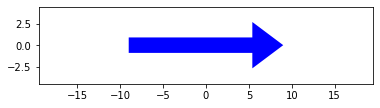

In [2]:
ureg = ice.ureg
sp = ice.spins(centers = np.array([[0,0,0]])*ureg.um, 
               directions = np.array([[30,0,0]])*ureg.um, 
               lattice_constant=10*ureg.um)
sp.display()

In [3]:
particle = ice.particle(radius = 1*ureg.um,
             susceptibility = 0,
             diffusion = 0.145*ureg.um**2/ureg.s,
             temperature = 300*ureg.K)

trap = ice.trap(trap_sep = 2*ureg.um,
               height = 16*ureg.pN*ureg.nm,
               stiffness = 1*ureg.fN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0)
col.pad_region(3*ureg.um)

world = ice.world(
    field = 0*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

In [4]:
%%time 
col.simulation(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = 10*ureg.Hz,
             timestep = 1000*ureg.us,
             run_time = 10000*ureg.s,
             output = ["x","y","z","fx","fy","fz"])

CPU times: user 3.71 ms, sys: 176 µs, total: 3.88 ms
Wall time: 3.86 ms


In [5]:
%%time 
col.run_simulation()
col.load_simulation()

CPU times: user 5min 28s, sys: 5.63 s, total: 5min 33s
Wall time: 8min 9s


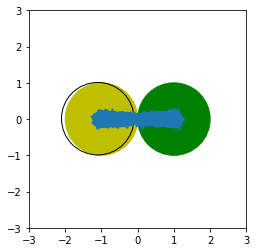

In [6]:
col.display()
plt.plot(col.trj[col.trj.type==1].x, col.trj[col.trj.type==1].y)

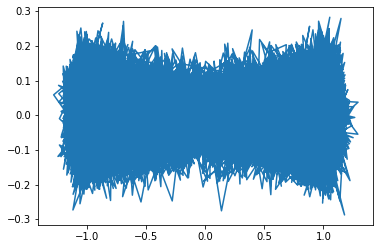

In [7]:
plt.plot(col.trj[col.trj.type==1].x, col.trj[col.trj.type==1].y)

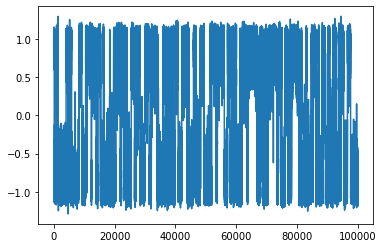

In [8]:
plt.plot(col.trj[col.trj.type==1].x.values)

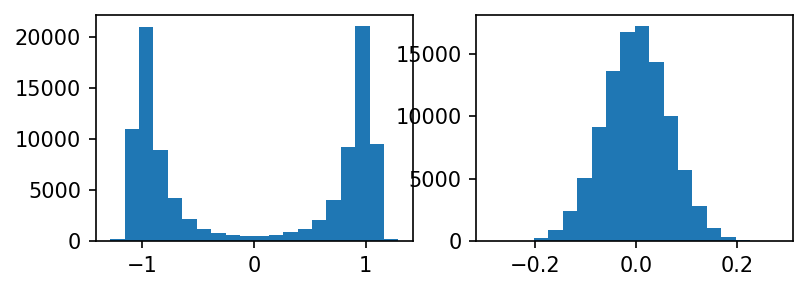

In [9]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)
ax[0].hist(col.trj[col.trj.type==1].x, bins=20);
ax[1].hist(col.trj[col.trj.type==1].y, bins=20);

In [10]:
kB = 1.38064852e-23*ureg.J/ureg.K

/Users/aortiza/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


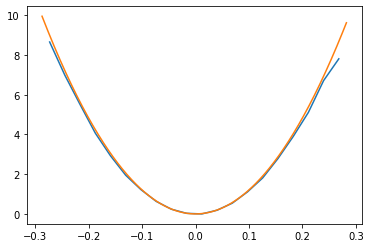

In [11]:
[p, x] = np.histogram(col.trj[col.trj.type==1].y, bins = 20, density=True)

plt.plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p))

k = col[0].trap.stiffness
x = np.linspace(min(x),max(x),1000) * ureg.um
T = col.sim.world.temperature

plt.plot(x, (k*x**2/2/(kB*T)).to("").magnitude)

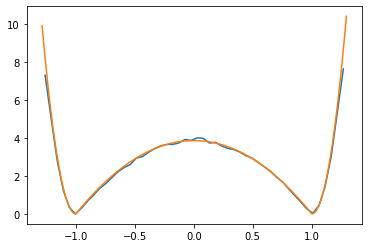

In [12]:
[p, x] = np.histogram(col.trj[col.trj.type==1].x, bins = 50, density=True)

plt.plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p))

x = np.linspace(min(x),max(x),1000) * ureg.um

k = col[0].trap.stiffness
d = col[0].trap.trap_sep
h = col[0].trap.height
T = col.sim.world.temperature

U1 = (k * (abs(x)-d/2)**2 / 2).to(ureg.pN * ureg.nm)
U2 = (h*(1-4 * (x)**2/d**2)).to(ureg.pN * ureg.nm)
U = U2
U[abs(x)>(d/2)] = U1[abs(x)>(d/2)]

plt.plot(x,(U/(kB*T)).to("").magnitude)

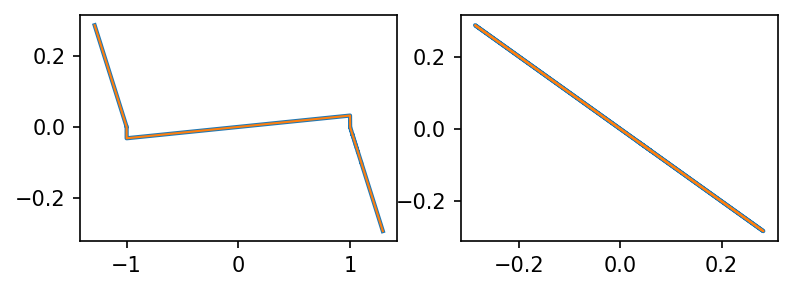

In [13]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)
forces = col.trj[col.trj.type==1]
forces = forces.sort_values(by="x")

x = forces.x
y = forces.y

fx = forces.fx * (1*ureg.pg*ureg.um/ureg.us**2).to(ureg.pN).magnitude
fy = forces.fy * (1*ureg.pg*ureg.um/ureg.us**2).to(ureg.pN).magnitude

F1 = -np.sign(x)*(abs(x)-d.magnitude/2)*(k.to(ureg.pN/ureg.um).magnitude)
F2 = x*(8*h/d**2).to(ureg.pN/ureg.um).magnitude
Fx = F2
Fx[abs(x)>(d.magnitude/2)] = F1[abs(x)>(d.magnitude/2)]

ax[0].plot(x,fx,linewidth = 2)
ax[0].plot(x, Fx,linewidth = 1)

Fy = -y*(k.to(ureg.pN/ureg.um).magnitude)

ax[1].plot(y,fy,linewidth = 2)
ax[1].plot(y,Fy,linewidth = 1)